### Validation Algorithm

Building a validation algorithm.

### Part 1: Reddit Confidence Score

We use Reddits ranking score to get a confidence score of current voting scenarios for a resource.

In [1]:
from math import sqrt
from matplotlib.cbook import boxplot_stats
import pandas as pd
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, seed

def confidence(ups, downs, confidence_score=0.90):
    #measure the total number of ratings
    n = ups + downs
    #what to do when there are no ratings
    if n == 0:
        return 0
    # finding the (1- confidence / 2) quantile of the standard normal distribution
    z = norm.ppf(1 - ((1 - confidence_score) / 2))
    #find the observed fraction of positive ratings
    p = ups / n
    #use Wilsons score interval to find the lower bound, essentially trying to answer
    # Given the ratings I have, there is a 80% chance (based on confidence score) that the
    # "real" fraction of positive ratings is at least what?
    #     we want the lower bound therefore only calculating that portion of formula
    #Calculate the left side of formula
    left_side = p + 1/(2*n)*z*z
    #Calculate the right side of formula
    right_side = z*sqrt(p*(1-p)/n + z*z/(4*n*n))
    #Calculate the bottom side of formula
    under = 1+1/n*z*z
    #return lower bound of score
    return (left_side - right_side) / under

In [2]:
#example voting scenario for a resource
upvotes = 14
downvotes = 2

print(f"Confidence for this scenario: {confidence(upvotes, downvotes)}")

Confidence for this scenario: 0.683786931501618


### Part 2: Implementing Decay Rate (Over Time)

In this step we implement a decay rate $\lambda$ that controls how the score is affected over time. We also want the rate of decay over time to be at a constant rate, so in order to do this we must use the exponential function. The exponential function helps ensure that time affects the score gradually and naturally as time passes.

Decay rate must be negative to ensure that we are measuring exponential decay rather than exponential growth.
$$score = p^\alpha * e^{-\lambda t}$$

We also include an $\alpha$ value to the reddit confidence score that measures the weight of that value in regards to the final score. Consider a sceneario where we have a resource with a confidence rating of 0.9 from the reddit step, we will see how changing the $\alpha$ state impacts the score over the course of 1 day.

|  | $\alpha = 0.8$ | $\alpha = 1$ | $\alpha = 1.2$ |
| :--:| :---: | :---: | :---: |
| score | 0.91125 | 0.89225 | 0.87365 |


#### How Decay Rate Affects Scores Over Time

Consider a scenario where a resources has a perfect score: $p = 1$. This is how time will affect that score with different decay rates.

| Time (Days) | $\lambda = 10^{-5}$ | $\lambda = 10^{-6}$ | $\lambda = 10^{-7}$ |
| :---------: | :-----------------: | :-----------------: | :-----------------: |
| 1 Day (86400s) | 0.406 | 0.913 | 0.991 |
| 3 Days (259200s) | 0.049 | 0.590 | 0.974 |
| 7 Days (604800s) | 0.0009 | 0.239 | 0.954 |

In [3]:
from math import exp

#build an updated score version
def score_v_one(upvotes, downvotes, time, alpha=0.8):
    #get the reddit confidence score
    p = confidence(upvotes, downvotes)
    #calculate p^alpha
    confidence_score = p ** alpha
    #calculate time part
    time_decay = exp(-(10**(-7))*time)
    return confidence_score * time_decay

In [4]:
#number of upvotes for a resource
upvotes = 20
#number of downvotes for a resource
downvotes = 2
#the time the resources has been up
days = 3
#time in seconds for formula
seconds = days * 86400

print(f"Score: {score_v_one(upvotes, downvotes, seconds)}")

Score: 0.7816252169974596


### Proposed Algo Formula

$$score = p^{0.8} \cdot e^{-10^{-7} \cdot t}$$

With a **validation threshold** of 0.65, which allows for a solid amount of resources to be used for training.

Where:
- $p$ is the confidence score received from Reddits ranking formula, calculated using **upvotes** and **downvotes**
- The value 0.8 allows for the confidence score to be weighed slightly more than time, in order to allow for good resources scores to be preserved more throughout time
- $e^{-10^{-7} \cdot t}$ allows for a solid decay rate that will preserve resources for a longer period of time



### Future Iterations of Formula

In the future if we want to include different variables into the formula, we could include those proportions like so.

For example, if we want to factor in the proportion of views to total users. The formula would look like this:

$$score = p^{0.8} \cdot v^{\beta} \cdot e^{-10^{-7} \cdot t}$$

Where:
- $v$ is the proportion of views / total users
- $\beta$ is the weight we would want to associate to the views proportion parameter

In [5]:
#build future iteration of score
def score_v_two(upvotes, downvotes, views, total_users, time, alpha=0.8, beta=0.05, delta=7):
    #get the reddit confidence score
    p = confidence(upvotes, downvotes)
    #calculate p^alpha
    confidence_score = p ** alpha
    #calculate viewership portion
    engagement = (views / total_users) ** beta
    #calculate time part
    time_decay = exp(-(10**(-delta))*time)
    return confidence_score * engagement * time_decay

In [6]:
#number of views
views = 40
#number of total users
total_users = 200

print(f"Updated Score: {score_v_two(upvotes, downvotes, views, total_users, seconds)}")

Updated Score: 0.7211906075562657


### Updated Formula With Engagement

$$score = p^{0.8} \cdot v^{0.05} \cdot e^{-10^{-7}\cdot t}$$

Where:
- $p$ is the confidence score given by the reddit algorithm, calculated using upvotes and downvotes
- $v$ measures the engagement or proportion of views / total users
- $e^{-10^{-7}\cdot t}$ measures the time decay of the resource

### Visualizing Distribution Of Scores From Simulated Scenarios

Simulated random scenarios to see how the score is distributed in order to arrive at a threshold

In [7]:
#set seed for reproducability
seed(42)
#build data list
data = []
#build rows of data
for i in range(10000):
    #get random upvote
    random_upvote = randint(1, 100)
    #get random downvote
    random_downvote = randint(1, 100)
    #get random day
    random_day = randint(1, 90)
    #calculate the seconds
    curr_seconds = random_day * 86400
    #get random views
    random_views = randint(1, 200)
    #get the score for current random scenario
    curr_score = score_v_two(random_upvote, random_downvote, random_views, 200, curr_seconds)
    #append data to list
    data.append([random_upvote, random_downvote, random_day, random_views, curr_score])

#build dataframe
df = pd.DataFrame(data, columns=["upvotes", "downvotes", "days", "views", "score"])

As we can see below the highest score was 0.924 and the lowest score was 0.003.

In [8]:
#get the sorted values
df.sort_values(by='score', ascending=False)

,upvotes,downvotes,days,views,score
7815,84,2,1,153,0.924726
6423,88,2,1,124,0.917350
7761,77,2,2,156,0.913099
985,57,2,2,179,0.900507
6660,88,3,4,137,0.887027
...,...,...,...,...,...
5749,1,86,66,112,0.004650
7715,1,74,76,41,0.004569
289,1,85,70,119,0.004548
1724,1,100,82,130,0.003621


Here we calcuate the percentiles, we found that:
- 90% of the scores were below 0.549
- 95% of the scores were below 0.628.

In [9]:
#get the score for 90th percentile
print(f"90th percentile score: {df.score.quantile(0.9)}")
#get the score for 95th percentile
print(f"95th percentile score: {df.score.quantile(0.95)}")

90th percentile score: 0.5496815633438932
95th percentile score: 0.6287974974416446


<Axes: xlabel='score'>

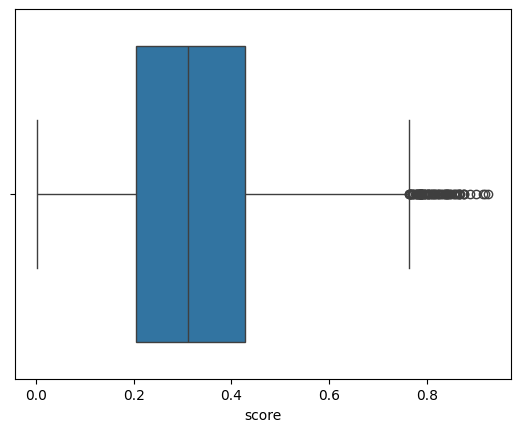

In [10]:
#visualize the box plot of scores
sns.boxplot(x=df["score"])

In [11]:
#save the stats of the boxplot for original simulated scores
box_stats = boxplot_stats(df["score"])
#get the lower whisker score
print(f"Lower Whisker: {box_stats[0]["whislo"]}")
#get the upper whisker score
print(f"Upper Whisker: {box_stats[0]["whishi"]}")
#get all rows excluding outliers
df_no_outliers = df[df["score"] <= box_stats[0]["whishi"]]
#calculate the 95th percentile for scores excluding outliers
print(f"95th percentile (excluding outliers): {df_no_outliers["score"].quantile(0.95)}")

Lower Whisker: 0.0034587590889681246
Upper Whisker: 0.7616874607618023
95th percentile (excluding outliers): 0.6123083115575447


Histrogram of the distribution of scores with a red line at the 95 percentile.

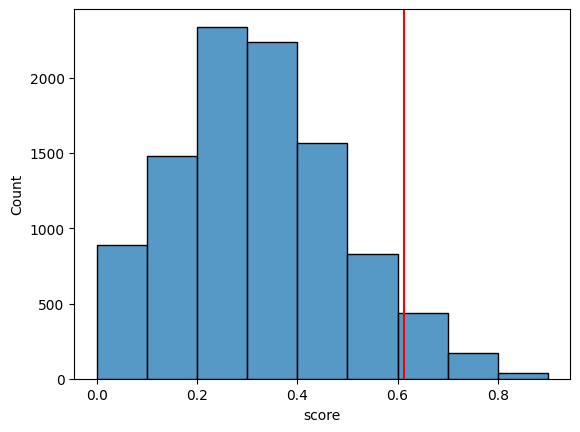

In [12]:
#histogram of the distribution of scores
sns.histplot(data=df, x="score", bins=np.arange(0, 1, 0.1))

plt.axvline(df_no_outliers["score"].quantile(0.95), color="red")

In [13]:
#get the outlier scores
df_outliers = df[df["score"] > box_stats[0]["whishi"]]
#see the results
df_outliers.sort_values(by=["score"], ascending=False)

,upvotes,downvotes,days,views,score
7815,84,2,1,153,0.924726
6423,88,2,1,124,0.917350
7761,77,2,2,156,0.913099
985,57,2,2,179,0.900507
6660,88,3,4,137,0.887027
...,...,...,...,...,...
6094,61,3,5,15,0.765368
615,73,6,4,21,0.764835
1972,87,7,14,99,0.763951
6170,57,2,20,144,0.762467


### Key TakeAways
- If downvotes > upvotes then score will be less than .50
- Most scores (around 95%) will fall below 0.62

We are going to run the same simulation but changing the weights of the variables to see how the distribution of the scores changes.

In [14]:
#set seed for reproducability
seed(42)
#build data list
data_two = []
#build rows of data
for i in range(10000):
    #get random upvote
    random_upvote = randint(1, 25)
    #get random downvote
    random_downvote = randint(1, 25)
    #get random day
    random_day = randint(1, 90)
    #calculate the seconds
    curr_seconds = random_day * 86400
    #get random views
    random_views = randint(1, 200)
    #get the score for current random scenario
    curr_score = score_v_two(random_upvote, random_downvote, random_views, 200, curr_seconds)
    #append data to list
    data_two.append([random_upvote, random_downvote, random_day, random_views, curr_score])

#build dataframe
df_two = pd.DataFrame(data_two, columns=["upvotes", "downvotes", "days", "views", "score"])

In [15]:
#get the score for 90th percentile
print(f"90th percentile score: {df_two.score.quantile(0.9)}")
#get the score for 95th percentile
print(f"95th percentile score: {df_two.score.quantile(0.95)}")

90th percentile score: 0.48389780148242195
95th percentile score: 0.5524831207374221


<Axes: xlabel='score'>

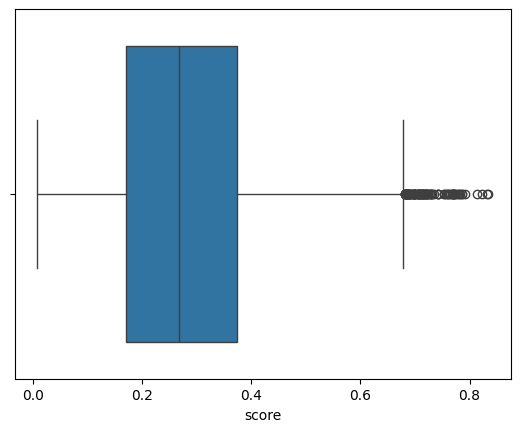

In [16]:
#visualize the box plot of scores
sns.boxplot(x=df_two["score"])

In [17]:
#save the stats of the boxplot for original simulated scores
box_stats_two = boxplot_stats(df_two["score"])
#get the outlier scores
df_two_outliers = df_two[df_two["score"] > box_stats_two[0]["whishi"]]
#see the results
df_two_outliers.sort_values(by=["score"], ascending=False)

,upvotes,downvotes,days,views,score
7815,21,1,1,153,0.834396
6423,22,1,1,124,0.831280
7761,20,1,2,156,0.821919
6660,22,1,4,137,0.814058
7320,19,1,2,87,0.791811
...,...,...,...,...,...
4080,16,3,1,80,0.682345
795,24,5,3,67,0.682266
9408,23,3,16,172,0.682105
2443,16,1,8,22,0.681149


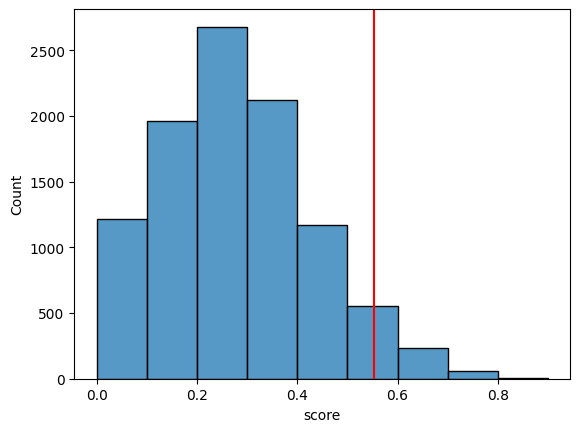

In [18]:
#histogram of the distribution of scores
sns.histplot(data=df_two, x="score", bins=np.arange(0, 1, 0.1))

plt.axvline(df_two.score.quantile(0.95), color="red")